# Final Project Submission

Please fill out:
* Student name: Deztany Jackson
* Student pace: DS Flex
* Scheduled project review date/time: March 23, 2023
* Instructor name: Morgan Jones
* Blog post URL: Dmvinedata.com

In [ ]:
"""References for Use:
    Transfer Learning: https://www.youtube.com/watch?v=fj9Y6T7mOyE <br>
    
"""

# Summary- 250 Words
    Business Problem
    Data Understanding
    Data Preparation
    Modeling
    Evaluation
    Conclusion

# Data Understanding


Write a few sentences on the approach to Data Understanding

In [142]:
import os # Getting data 
import glob #Google Collab
#from google.colab import drive #Google Collab

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.metrics import AUC, Accuracy,Precision,Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import models, layers, optimizers, regularizers, activations
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
#from sklearn.metrics import plot_confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16, VGG19 #Pretrained Transfer Modeling
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight #Unsure what this is for
#from sklearn.metrics import plot_precision_recall_curve 
import datetime

import pathlib
import shutil

import warnings
warnings.filterwarnings('ignore')
tf.__version__
#plot_confusion matrix

# Showing the areas of the image
#import lime
#from lime import lime_base
#from lime import lime_image
#from skimage.segmentation import mark_boundaries

'2.9.2'

In [ ]:
conda install 

In [2]:
#Time
original_start = datetime.datetime.now()
start = datetime.datetime.now()

In [4]:
#Load data
#Count each category
cur_dir = os.getcwd()
cur_dir


'/Users/deztanyjackson/Documents/0_Flatiron/Phase_4/Project_4/Image_Classification_P4'

In [5]:
#Puling data in...already know the categories from the problem
train_data = glob.glob(os.path.join(cur_dir,'data/chest_xray/train/**/*.jpeg'))
val_data = glob.glob(os.path.join(cur_dir,'data/chest_xray/val/**/*.jpeg'))
test_data = glob.glob(os.path.join(cur_dir,'data/chest_xray/test/**/*.jpeg'))

print("〰"*20)
print(f"Training Set has: {len(train_data)} images")
print(f"Testing Set has: {len(test_data)} images")
print(f"Validation Set has: {len(val_data)} images")
print("〰"*20)

〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰
Training Set has: 4352 images
Testing Set has: 624 images
Validation Set has: 880 images
〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰


In [6]:
DIR = "../chest_xray/"
sets = ["train", "val", "test"]
all_pneumonia = []
all_normal = []

for cat in sets:
    path = os.path.join(DIR, cat)
    norm = glob.glob(os.path.join(path, "NORMAL/*.jpeg"))
    pneu = glob.glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
    
    all_normal.extend(norm)
    all_pneumonia.extend(pneu)
print("〰"*20)
print(f"Total Pneumonia Images: {len(all_pneumonia)}")
print(f"Total Normal Images: {len(all_normal)}")
print(f"Ratio of Normal: {round(len(all_normal)/len(all_pneumonia),2)}")
print("〰"*20)

〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰
Total Pneumonia Images: 4273
Total Normal Images: 1583
Ratio of Normal: 0.37
〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰


In [7]:
v_pneu = glob.glob(os.path.join(cur_dir,'data/chest_xray/val/PNEUMONIA/*.jpeg'))
v_norm = glob.glob(os.path.join(cur_dir,'data/chest_xray/val/NORMAL/*.jpeg'))
t_norm = glob.glob(os.path.join(cur_dir,'data/chest_xray/train/NORMAL/*.jpeg'))
t_pneu = glob.glob(os.path.join(cur_dir,'data/chest_xray/train/PNEUMONIA/*.jpeg'))
test_norm = glob.glob(os.path.join(cur_dir,'data/chest_xray/train/NORMAL/*.jpeg'))
test_pneu = glob.glob(os.path.join(cur_dir,'data/chest_xray/train/PNEUMONIA/*.jpeg'))

In [8]:
#Moving Validation to Test


cat = [v_norm,v_pneu]

for c in cat:
    if c == v_norm:
        images = [f for f in v_norm if '.jpeg' in f.lower()] 
        for img in images:
            new_path = os.path.join(cur_dir,"data/chest_xray/train/NORMAL/")
            shutil.move(img,new_path)
    elif c == v_pneu:
        images = [f for f in v_pneu if '.jpeg' in f.lower()] 
        for img in images:
            new_path = os.path.join(cur_dir,"data/chest_xray/train/PNEUMONIA/")
            shutil.move(img,new_path)
    else:
        pass


In [9]:
train_cat = [t_norm,t_pneu]

for cat in train_cat:
    train,val = train_test_split(cat, train_size=.8, random_state=42)
    if cat == t_norm:
        for img in val:
            new_path = os.path.join(cur_dir,"data/chest_xray/val/NORMAL/")
            shutil.move(img,new_path)
    elif cat == t_pneu:
        for img in val:
            new_path = os.path.join(cur_dir,"data/chest_xray/val/PNEUMONIA/")
            shutil.move(img,new_path)
    else:
        pass
    

In [10]:
v_pneu = glob.glob(os.path.join(cur_dir,'data/chest_xray/val/PNEUMONIA/*.jpeg'))
v_norm = glob.glob(os.path.join(cur_dir,'data/chest_xray/val/NORMAL/*.jpeg'))
t_norm = glob.glob(os.path.join(cur_dir,'data/chest_xray/train/NORMAL/*.jpeg'))
t_pneu = glob.glob(os.path.join(cur_dir,'data/chest_xray/train/PNEUMONIA/*.jpeg'))
test_norm = glob.glob(os.path.join(cur_dir,'data/chest_xray/train/NORMAL/*.jpeg'))
test_pneu = glob.glob(os.path.join(cur_dir,'data/chest_xray/train/PNEUMONIA/*.jpeg'))

In [11]:
print("〰"*20)
print(f"Training Set has: {len(train_data)} images")
print(f"Testing Set has: {len(test_data)} images")
print(f"Validation Set has: {len(val_data)} images")
print("〰"*20)

〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰
Training Set has: 4352 images
Testing Set has: 624 images
Validation Set has: 880 images
〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰


In [12]:
print(f"Validation Pneumonia Amount: {len(v_pneu)} images")
print(f"Validation Normal Amount: {len(v_norm)} images")
print(f"Validation Normal to Pneumonia Ratio: {round(len(v_norm)/len(v_pneu),2)}")


Validation Pneumonia Amount: 646 images
Validation Normal Amount: 225 images
Validation Normal to Pneumonia Ratio: 0.35


There is still imbalance but better offset

In [13]:
# Graph of Pneumonia to Normal count (All, Train, Val, Test)
#Visualize samples from Normal and Pneumonia

Sample of Random Normal Pictures


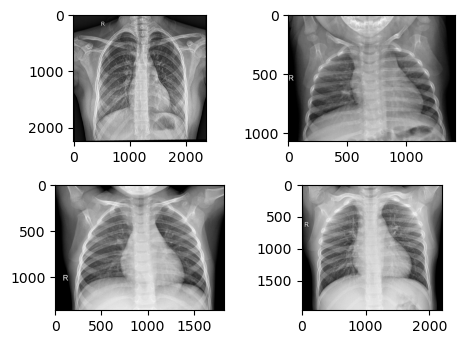

In [14]:
plt.figure(figsize = (5,5))
print ("Sample of Random Normal Pictures")
for i in range(4):
    plt.subplot(3,2,i+1)
    img = plt.imread(t_norm[i])
    plt.imshow(img, cmap = "gray")
    plt.tight_layout()
    #plt.axis('off')

Sample of Random Pneumonia Pictures


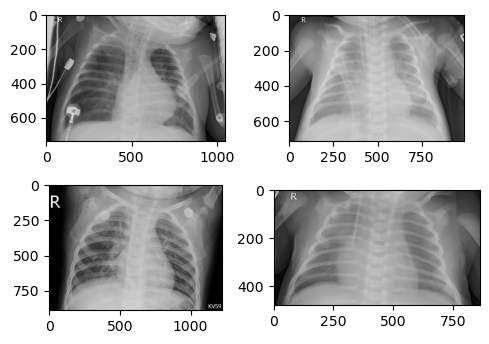

In [15]:
plt.figure(figsize = (5,5))
print ("Sample of Random Pneumonia Pictures")
for i in range(4):
    plt.subplot(3,2,i+1)
    img = plt.imread(t_pneu[i])
    plt.imshow(img, cmap = "gray")
    plt.tight_layout()
    #plt.axis('off')

Visually, both the Normal and Pneumonia pictures vary in size. Pneumonia pictures have a cloudier look.

#Reschaling the image [Rescaling](https://datascience.stackexchange.com/questions/92499/rescale-parameter-in-data-augmentation#:~:text=As%20rightly%20pointed%20out%20by,evenly%20to%20the%20total%20loss)

In [16]:
#ImageDataGenerator without data augmentation

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [17]:
#Directories
train_directory= 'data/chest_xray/train'
validation_directory= 'data/chest_xray/val'
test_directory = 'data/chest_xray/test'


## Image Generator

Describe:
- Target Size
- Batch Size
- Class Mode
- Shuffle

In [250]:
#Using a generator for the images to work with.
train_gen = train_datagen.flow_from_directory(train_directory,
                                                   target_size = (224, 224),
                                                   batch_size=32,
                                                   classes = ["NORMAL","PNEUMONIA"],
                                                   class_mode = 'binary',
                                                   
                                                   seed = 42)

val_gen = val_datagen.flow_from_directory(validation_directory,
                                                      target_size = (224, 224),
                                                      batch_size = 32,
                                                      classes = ["NORMAL","PNEUMONIA"],
                                                      class_mode = 'binary',
                                                      seed = 42)
test_gen = test_datagen.flow_from_directory(test_directory,
                                                      target_size = (224, 224),
                                                      batch_size = 32,
                                                      classes = ["NORMAL","PNEUMONIA"],
                                                      class_mode = 'binary',
                                                      seed = 42,
                                                      shuffle= False)                                                      

Found 4361 images belonging to 2 classes.
Found 871 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [19]:
#Checking the class label and index match
print(train_gen.class_indices)
print(val_gen.class_indices)

{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}


In [242]:
X_train, y_train = next(train_gen)
X_test, y_test = next(test_gen)
X_val, y_val = next(val_gen)

[4273, 1583]


<Axes: ylabel='count'>

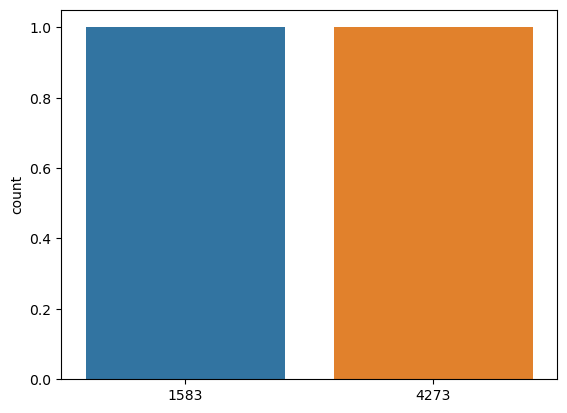

In [21]:
"""# Plot the count fo the Pneumonia for All and Training using the X and y

labels = [ "Pneumonia", "Normal"]
values = [len(all_pneumonia), len(all_normal) ]
colors = ["orange", "blue"]
print(values)
sns.countplot(x = values, label = labels)

#Distribution of Category Variables
fig,ax=plt.subplots(figsize=(8,8), facecolor = "white")
sns.countplot(x = "Category", data=train_gen)
plt.title('Distribution of Categories on Data')
plt.grid(axis = "y")
plt.show()
fig.savefig("images/dist.png", dpi=150)"""

In [22]:
#Import data
#Count Images, Count Class
#Plot distribution of count
#Plot pictures of Pnuemonia and Normal x2
#Plot distribution of count
#Check shape
#Why does data need to be normalized? Describe why 

[Visualization Metrics,A.Jang 2023](https://www.kaggle.com/code/amyjang/tensorflow-pneumonia-classification-on-x-rays#8.-Visualizing-model-performance)

### Custom Functions 

In [190]:
def eval_metrics(history):
    """ Enter Docstring information Plotting the accuracy and the loss of the training and validation model"""
    
    fig, ax = plt.subplots(1,4, figsize = (25,5))
    fig.suptitle('Model Metrics Results')
    
    metrics = ["acc","loss","recall","precision"]   
    
    for i, metric in enumerate(metrics):
    
        ax[i].plot(history.history[metric])
        ax[i].plot(history.history["val_" + metric])
        ax[i].set_title('Model {}'.format(metric))
        ax[i].set_ylabel(metric)
        ax[i].set_xlabel("Epochs")
        ax[i].legend(['train', 'val'])

        

[Predictor Algorithm with Shuffle,by Jakob, 2021](https://stackoverflow.com/questions/45413712/keras-get-true-labels-y-test-from-imagedatagenerator-or-predict-generator/67282636#67282636)

In [89]:
def predict_results(model, generator):
    """Generator with shuffle = True"""
    
    # Create lists for storing the predictions and labels
    predictions = []
    labels = []

    # Get the total number of labels in generator 
    # (i.e. the length of the dataset where the generator generates batches from)
    n = len(generator.labels)

    # Loop over the generator
    for data, label in generator:
        # Make predictions on data using the model. Store the results.
        predictions.extend(model.predict(data).flatten())

        # Store corresponding labels
        labels.extend(label)

        # We have to break out from the generator when we've processed 
        # the entire once (otherwise we would end up with duplicates). 
        if (len(label) < generator.batch_size) and (len(predictions) == n):
            break
        return labels, predictions #y_true, y_hat_train/y_pred

In [126]:
def conf_matrix(y_true,y_pred, norm_bool):
    
    y_pred = np.round(y_pred,0) #Rounding to the nearest 0 or 1, assumes threshold is >.5 for
    cmatrix= cm(y_true, y_pred, normalize=norm_bool)
    matrix_disp= ConfusionMatrixDisplay(cmatrix, display_labels= ["NORMAL", "PNUEMONIA"])
    matrix_disp.plot()

    plt.xlabel('Predictions')
    plt.ylabel('Actual')
    plt.title('Model Confusion Matrix')
    plt.show()
    

In [214]:
def eval_report(y_true, y_pred,gen):
    
    y_pred = np.round(y_pred,0) # Rounding to the nearest 0 or 1
    #Display Precision, Recall, F1 and Accuracy
    print(classification_report(y_true, y_pred))
    print('\n')
    
    #Display Model Metrica
    loss, acc, recall, precision = history.model.evaluate(gen)
    print(f'Loss: {loss}')
    

In [177]:
# set up the class weights using y_train
def calc_weight(labels):
    """ Setting the weights and pairing it with the classes for the class weight paramters in model.fit. 
    Labels can also be thought of as y_train"""
    classes = [0,1]
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=labels)
    class_weights = dict(zip(classes, weights))
    return class_weights

In [44]:
#If needed
# def plot_roc_auc():
# def plot_roc_auc():

# Modeling


Write out the layout of each modeling iteration
- sequence <br>
- compile <br>
- summary <br>
- fit <br>
- predict <br>
- conf_matrix <br>
- eval report <br>
- Each iteration will have slight changes for improvement.  They will be described more at the
- General descriptions of  iterations

# Baseline Modeling

Describe the parameters anc choices made
- model sequence layers, filter, activation 
-compile


In [196]:
baseline = models.Sequential([
Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
       padding = 'same', input_shape=(224,224,3)),
MaxPooling2D(pool_size=(2, 2), strides=2), 
    
Conv2D(filters=64, kernel_size=(3, 3), activation='relu', 
       padding = 'same'),
MaxPooling2D(pool_size=(2, 2), strides=2),
    
Conv2D(filters=96, kernel_size=(3, 3), activation='relu', 
       padding = 'same'),
MaxPooling2D(pool_size=(2, 2), strides=2),
Flatten(),
Dense(units=64, activation='sigmoid'),    
Dense(units=1, activation='sigmoid'),
])

In [197]:
#Compile
baseline.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=["acc","Recall","Precision"])

In [198]:
baseline.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 56, 56, 96)        55392     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 28, 28, 96)      

In [ ]:
#describe the learned parameters in summary - DeepLizard

In [199]:
history = baseline.fit(train_gen,
                       epochs=10,
                       verbose = 2,
                       validation_data=val_gen)

Epoch 1/10


2023-03-23 20:13:36.694645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-23 20:13:54.844136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


88/88 - 22s - loss: 0.2700 - acc: 0.8805 - recall: 0.9333 - precision: 0.9083 - val_loss: 0.1454 - val_acc: 0.9460 - val_recall: 0.9876 - val_precision: 0.9424 - 22s/epoch - 252ms/step
Epoch 2/10
88/88 - 20s - loss: 0.1063 - acc: 0.9622 - recall: 0.9728 - precision: 0.9761 - val_loss: 0.0748 - val_acc: 0.9701 - val_recall: 0.9799 - val_precision: 0.9799 - 20s/epoch - 232ms/step
Epoch 3/10
88/88 - 20s - loss: 0.0826 - acc: 0.9706 - recall: 0.9805 - precision: 0.9799 - val_loss: 0.0720 - val_acc: 0.9747 - val_recall: 0.9783 - val_precision: 0.9875 - 20s/epoch - 228ms/step
Epoch 4/10
88/88 - 19s - loss: 0.0731 - acc: 0.9745 - recall: 0.9808 - precision: 0.9848 - val_loss: 0.0813 - val_acc: 0.9701 - val_recall: 0.9938 - val_precision: 0.9669 - 19s/epoch - 219ms/step
Epoch 5/10
88/88 - 21s - loss: 0.0680 - acc: 0.9755 - recall: 0.9815 - precision: 0.9854 - val_loss: 0.0784 - val_acc: 0.9736 - val_recall: 0.9938 - val_precision: 0.9713 - 21s/epoch - 234ms/step
Epoch 6/10
88/88 - 21s - loss: 

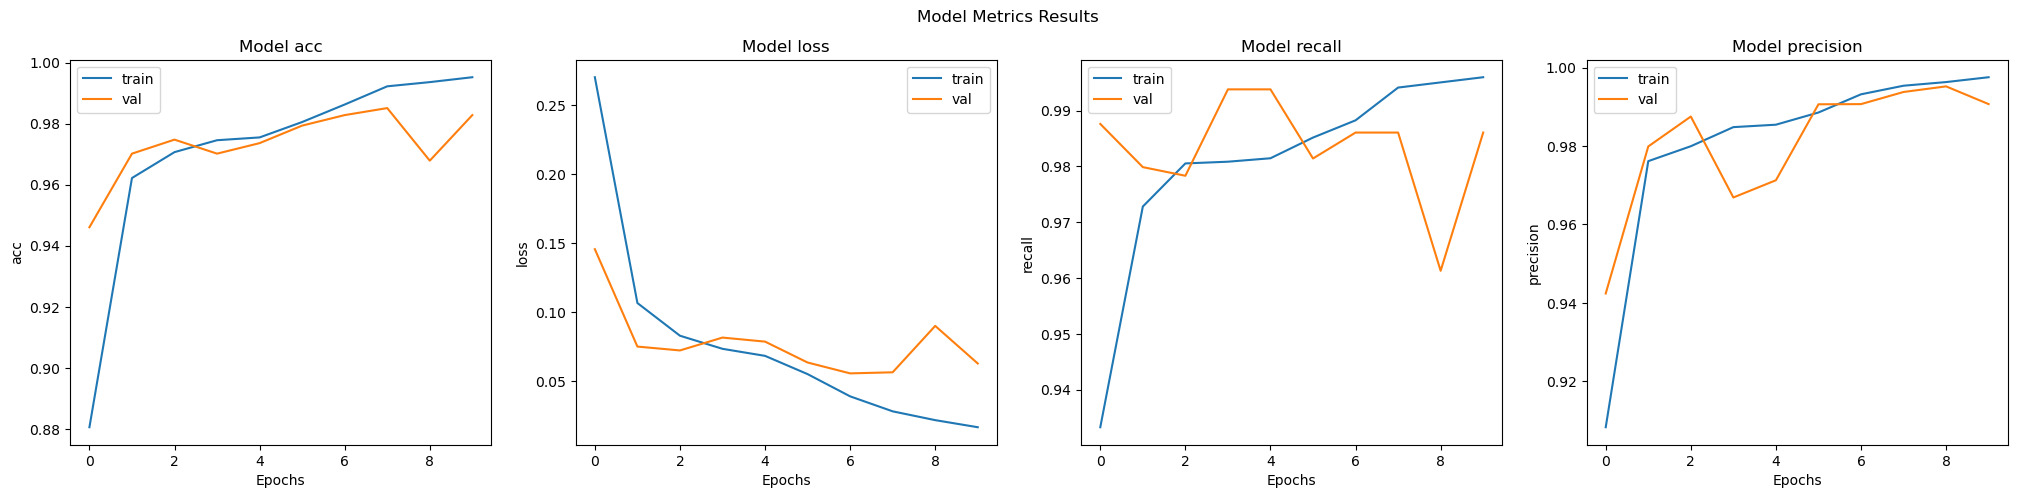

In [225]:
#Plotting chosen metrics
eval_metrics(history)

In [204]:
train_labels, train_predictions = predict_results(baseline,train_gen)
val_labels, val_predictions = predict_results(baseline,val_gen)

2/2 [==============================] - 0s 113ms/step


Training Confusion Matrices:



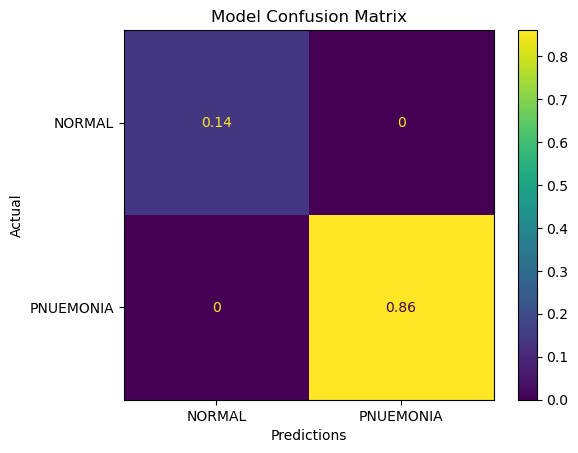

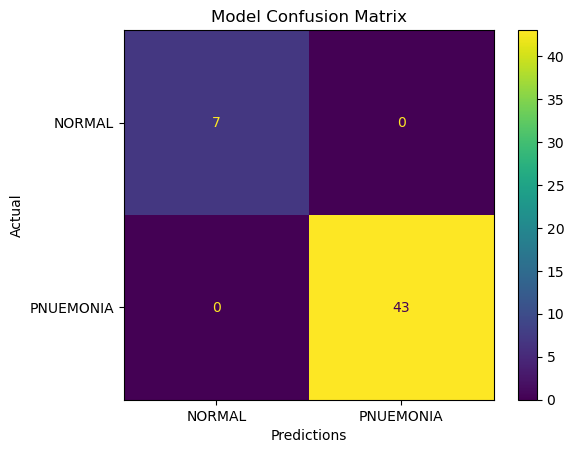

Validation Confusion Matrices:



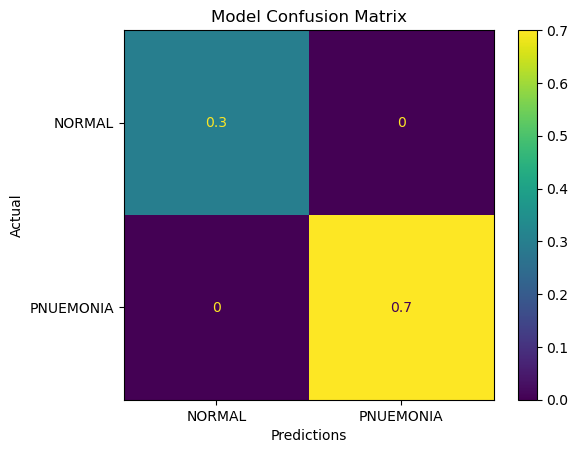

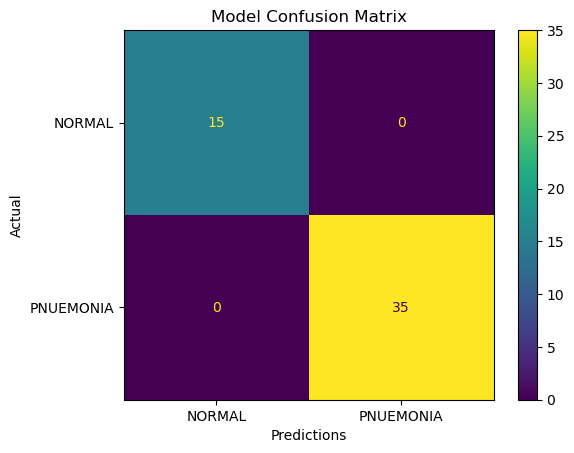

In [210]:
#Printing regular and normalized Confusion Matrices
print("Training Confusion Matrices:\n")
conf_matrix(train_labels,train_predictions, "all")
conf_matrix(train_labels,train_predictions, None)
print("Validation Confusion Matrices:\n")
conf_matrix(val_labels, val_predictions, "all")
conf_matrix(val_labels, val_predictions, None)

In [216]:
#Training Classification Report
print("Training Classificaiton Report:\n")
eval_report(train_labels,train_predictions,train_gen)

Training Classificaiton Report:

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         7
         1.0       1.00      1.00      1.00        43

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



88/88 [==============================] - 15s 172ms/step - loss: 0.0129 - acc: 0.9979 - recall: 0.9981 - precision: 0.9991
Loss: 0.012907564640045166


In [215]:
#Validation Classification Report
print("Validation Classificaiton Report:\n")
eval_report(val_labels,val_predictions,val_gen)

Validation Classificaiton Report:

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        15
         1.0       1.00      1.00      1.00        35

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



18/18 [==============================] - 3s 176ms/step - loss: 0.0625 - acc: 0.9828 - recall: 0.9861 - precision: 0.9907
Loss: 0.062490314245224


# Baseline Model with Class Weights 

Adding class weights to see it helps with class imbalance.


In [226]:

baseline2 = models.Sequential([
Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
       padding = 'same', input_shape=(224,224,3)),
MaxPooling2D(pool_size=(2, 2), strides=2), 
    
Conv2D(filters=64, kernel_size=(3, 3), activation='relu', 
       padding = 'same'),
MaxPooling2D(pool_size=(2, 2), strides=2),
    
Conv2D(filters=96, kernel_size=(3, 3), activation='relu', 
       padding = 'same'),
MaxPooling2D(pool_size=(2, 2), strides=2),
Flatten(),
Dense(units=64, activation='sigmoid'),    
Dense(units=1, activation='sigmoid'),
])

In [ ]:
#Run the others the sames as the baseline and look at the results...What is your assessment? Make an action

In [227]:
baseline2.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=["acc","Recall","Precision"]
                 )

In [228]:
#Calculating class weights for imbalance
class_weights = calc_weight(y_train)
class_weights

{0: 2.0833333333333335, 1: 0.6578947368421053}

In [229]:
history2 = baseline2.fit(train_gen,
                       epochs=10,
                       verbose = 2,
                       class_weight=class_weights,
                       validation_data=val_gen)

Epoch 1/10


2023-03-23 23:08:03.039871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-23 23:08:19.806068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


88/88 - 20s - loss: 0.3184 - acc: 0.8571 - recall: 0.8400 - precision: 0.9628 - val_loss: 0.1213 - val_acc: 0.9506 - val_recall: 0.9520 - val_precision: 0.9809 - 20s/epoch - 232ms/step
Epoch 2/10
88/88 - 20s - loss: 0.1306 - acc: 0.9537 - recall: 0.9490 - precision: 0.9881 - val_loss: 0.1474 - val_acc: 0.9392 - val_recall: 0.9567 - val_precision: 0.9611 - 20s/epoch - 223ms/step
Epoch 3/10
88/88 - 20s - loss: 0.1022 - acc: 0.9606 - recall: 0.9558 - precision: 0.9907 - val_loss: 0.0899 - val_acc: 0.9736 - val_recall: 0.9954 - val_precision: 0.9698 - 20s/epoch - 229ms/step
Epoch 4/10
88/88 - 20s - loss: 0.0877 - acc: 0.9686 - recall: 0.9642 - precision: 0.9933 - val_loss: 0.0969 - val_acc: 0.9598 - val_recall: 0.9551 - val_precision: 0.9904 - 20s/epoch - 229ms/step
Epoch 5/10
88/88 - 20s - loss: 0.0702 - acc: 0.9745 - recall: 0.9707 - precision: 0.9949 - val_loss: 0.0781 - val_acc: 0.9770 - val_recall: 0.9923 - val_precision: 0.9771 - 20s/epoch - 230ms/step
Epoch 6/10
88/88 - 20s - loss: 

In [230]:
baseline2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 56, 56, 96)        55392     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 28, 28, 96)      

Basline Evaluation Metrics :



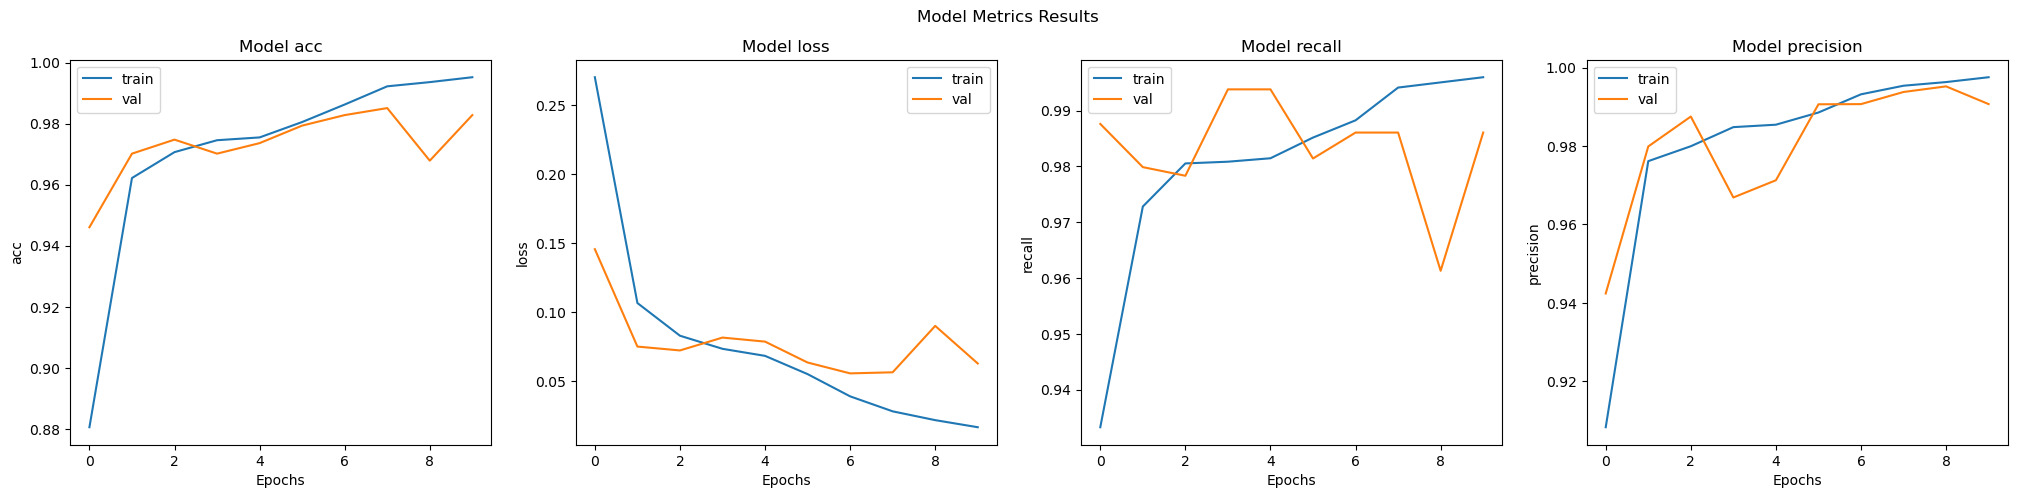

In [237]:
print("Basline Evaluation Metrics :\n")
eval_metrics(history)


Basline Evaluation Metrics w/ Class Weights :



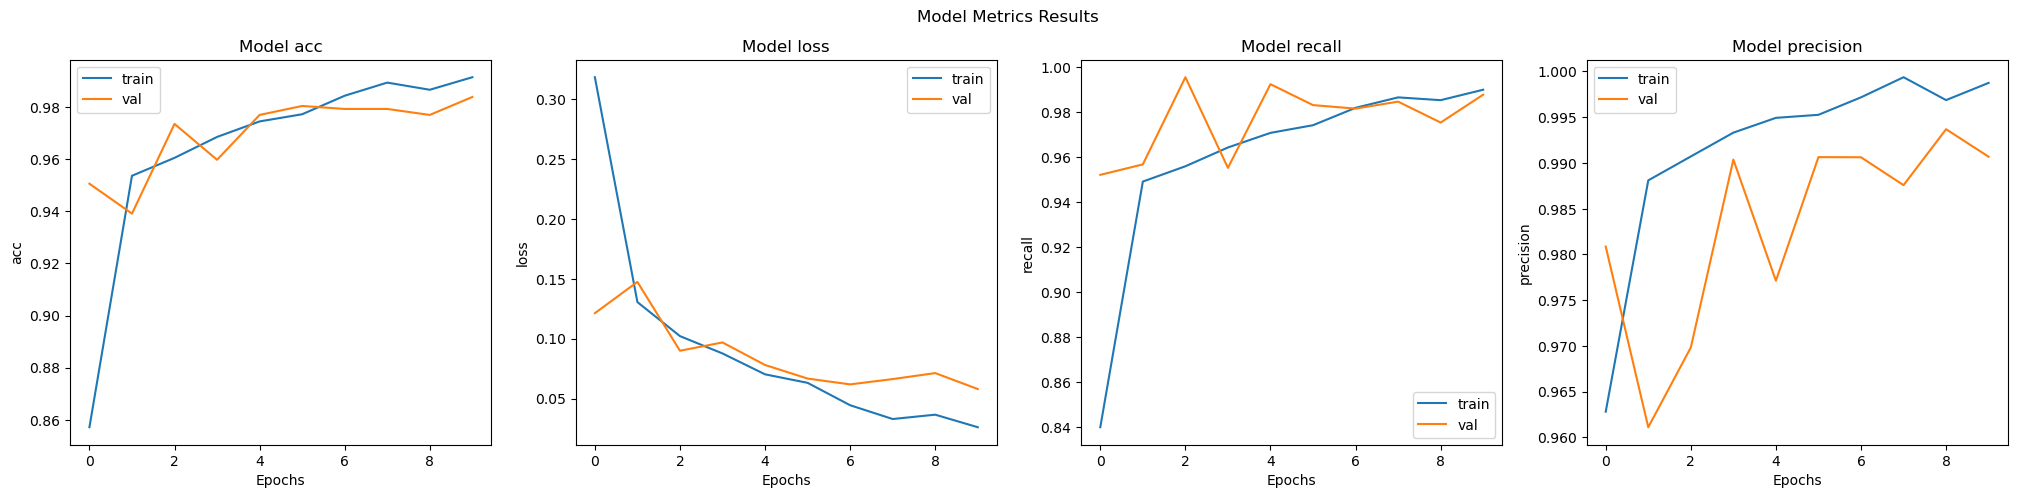

In [238]:
print("Basline Evaluation Metrics w/ Class Weights :\n")
eval_metrics(history2)

The model with class weights metrics are similar to the one without. The recall and precision plots show that validation data has a higher variation that without class weights. The concludes that the model is still overfitting.

In [232]:
train_labels, train_predictions = predict_results(baseline2,train_gen)
val_labels, val_predictions = predict_results(baseline2,val_gen)

2/2 [==============================] - 0s 33ms/step


Training Confusion Matrices:



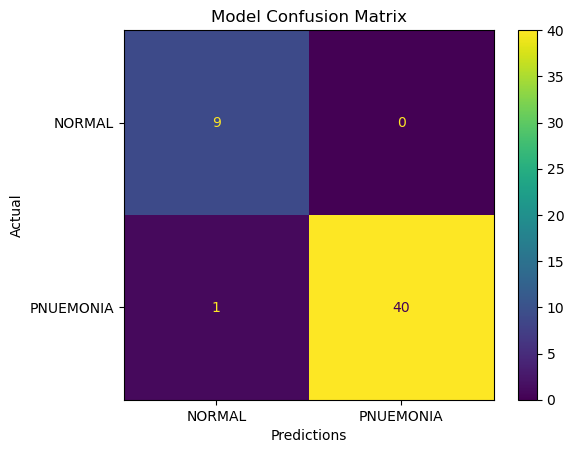

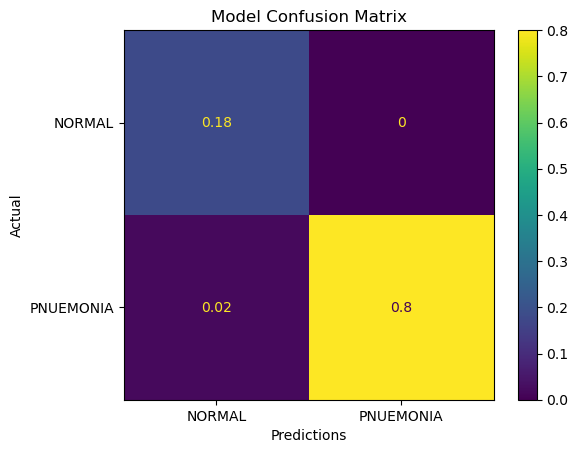

Validation Confusion Matrices:



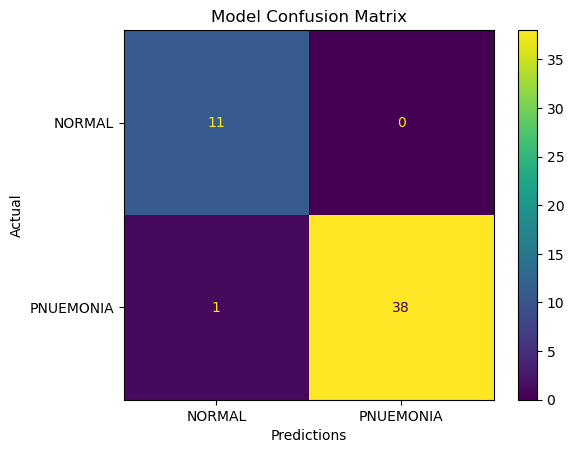

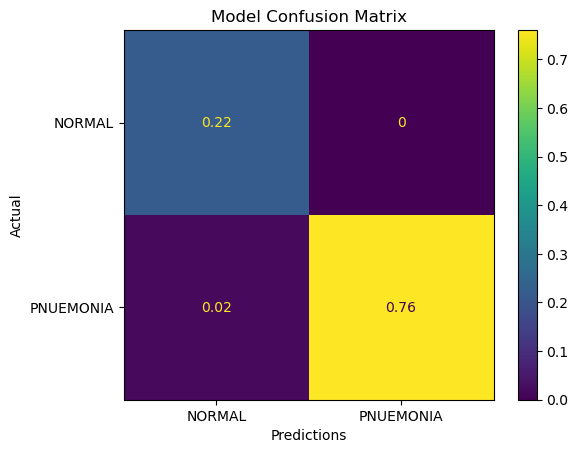

In [234]:
#Printing regular and normalized Confusion Matrices
print("Training Confusion Matrices:\n")
conf_matrix(train_labels,train_predictions, None)
conf_matrix(train_labels,train_predictions, "all")
print("Validation Confusion Matrices:\n")
conf_matrix(val_labels, val_predictions, None)
conf_matrix(val_labels, val_predictions, "all")

In [239]:
#Training Classification Report
print("Training Classificaiton Report:\n")
eval_report(train_labels,train_predictions,train_gen)

Training Classificaiton Report:

              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95         9
         1.0       1.00      0.98      0.99        41

    accuracy                           0.98        50
   macro avg       0.95      0.99      0.97        50
weighted avg       0.98      0.98      0.98        50



88/88 [==============================] - 15s 171ms/step - loss: 0.0129 - acc: 0.9979 - recall: 0.9981 - precision: 0.9991
Loss: 0.012907566502690315


In [240]:
#Training Classification Report
print("Validation Classificaiton Report:\n")
eval_report(val_labels,val_predictions,val_gen)

Validation Classificaiton Report:

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96        11
         1.0       1.00      0.97      0.99        39

    accuracy                           0.98        50
   macro avg       0.96      0.99      0.97        50
weighted avg       0.98      0.98      0.98        50



18/18 [==============================] - 3s 173ms/step - loss: 0.0625 - acc: 0.9828 - recall: 0.9861 - precision: 0.9907
Loss: 0.0624903105199337


# Model Iteration 3

In [ ]:
#Reformat Baseline models... Assess and if overfitting change add dropout

In [ ]:
#Droout, data augmentation, added some layers...After about 5 maybe change batch size..